#어텐션

seq2seq 모델은 인코더에서 입력 시퀀스를 하나의 컨텍스트 벡터로 압축하여 이 컨텍스트 벡터를 디코더로 입력하였다.

**seq2seq의 문제점**
1. 하나의 고정된 Context Vector를 사용하기 때문에 정보 손실이 발생한다.
2. RNN의 vanishing gradient 문제가 발생한다.

즉, 입력 sequence가 길어지면, 출력 sequence의 정확도가 떨어진다.



**Attention의 기본 아이디어**

디코더에서 출력 단어를 예측하는 매 timestep마다 인코더에서 전제 입력 문장을 다시 한번 참고하는 것이다. 이때, 모든 부분을 중요하게 생각하는 것이 아니라, 해당 timestep에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 Attentive하게 보는 것이다.



**Attention의 원리**

Encoder의 Timestep: 1~N

Encoder의 Hidden state: h_1~h_N

Decoder의 t에서의 Hidden state: s_t

Attention이 seq2seq의 단점을 보완하는 방법은 decoder의 예측값을 구할 때, 정보 손실을 막기 위해서 입력 문장을 또 다시 고려하는 것이다. 이때, 입력 문장 중 어떤 것을 중요하게 생각해야 하는지 알아내기 위해서 Attention value를 구하는 것이다.

*Attention Value를 구하는 방법*

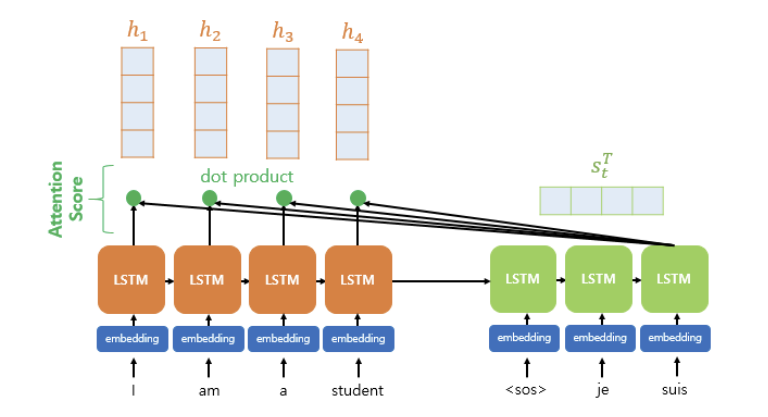

1. Attention Score 구하기
Attention score: 현재 디코더의 시점 t에서 단어를 예측하기 위해 인코더의 모든 은닉 상태 (h_1, ... h_N) 각각이 얼마나 디코더의 현 시점 hidden state s_t와 유사한지 판단하는 지표이다.

Attention 중 Dot Product Attention을 이용한다고 가정하자.

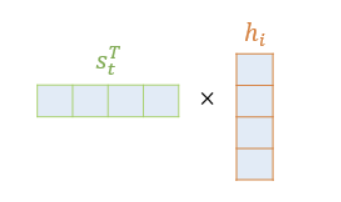

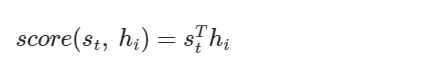

score() 함수는 dot product를 통해 s_t와 인코더의 hidden state와의 유사도를 구한다.

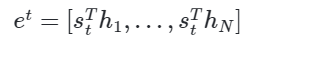

인코더의 모든 hidden state와 s_T의 유사도의 집합을 e_t로 정의한다.

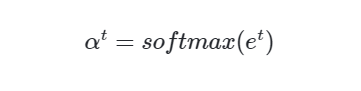

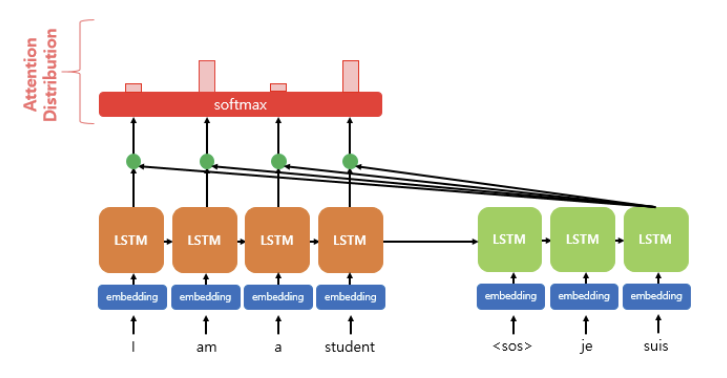

이 e_t를 softmax 함수를 통해 Attention Distribution을 만든다. Softmax를 통해 모든 값들이 0~1으로 변하기 때문에 Weight 역할을 한다고 볼 수 있다.

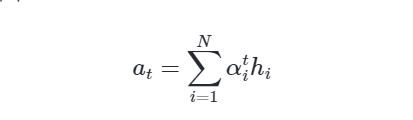

이제 Attention value를 얻기 위해 Attention Distribution의 weight를 corresponding한 encoder hidden state에 곱해서 모두 더해 weighted sum을 구한다. 이 a_t를 **Attention value**, 또는 **Context vector**라고 볼 수 있다.

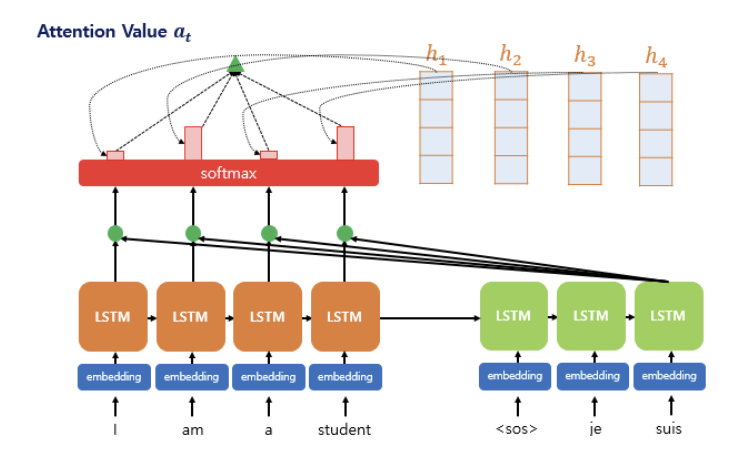

2. 구한 Attention Value와 s_t를 연결(concatenate)하여 v_t 벡터를 만든다.

이 v_t에는 rnn의 결과와 입력 sequence를 중요도만큼 가져온 결과를 가지고 있게 되는 것이다. 이를 통해 information loss 없이 더 잘 예측할 수 있게 되는 것이다.

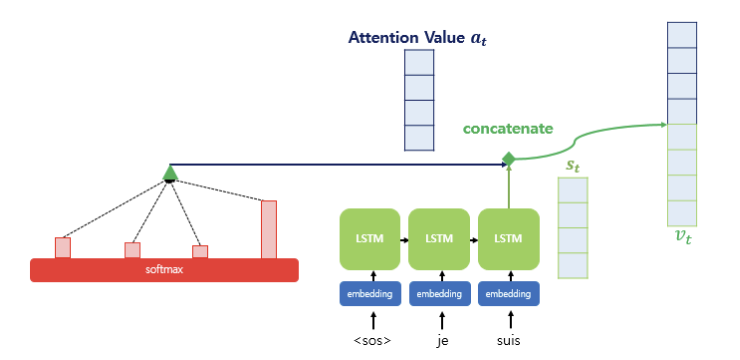

3. 출력층의 연산의 입력이 되는 s^_t를 계산한다.

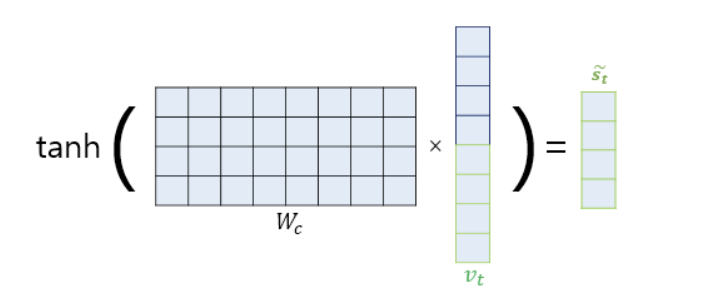

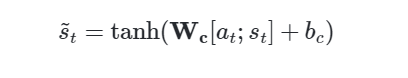

4. s^_t를 출력층의 입력으로 사용한다.

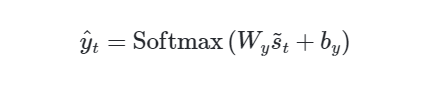

#Attention을 이용하여 개선된 번역기

전처리 과정은 seq2seq을 사용한 것과 동일하게

In [1]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import torch
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset


In [2]:
!wget -c http://www.manythings.org/anki/fra-eng.zip && unzip -o fra-eng.zip

--2024-03-21 08:05:17--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  15.0MB/s    in 0.5s    

2024-03-21 08:05:18 (15.0 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [3]:
num_samples = 33000


In [4]:
def unicode_to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess_sentence(sent):
  # 악센트 삭제 함수 호출
  sent = unicode_to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백을 만듭니다.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target


In [5]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()


In [7]:
def build_vocab(sents):
  word_list = []

  for sent in sents:
      for word in sent:
        word_list.append(word)

  # 각 단어별 등장 빈도를 계산하여 등장 빈도가 높은 순서로 정렬
  word_counts = Counter(word_list)
  vocab = sorted(word_counts, key=word_counts.get, reverse=True)

  word_to_index = {}
  word_to_index['<PAD>'] = 0
  word_to_index['<UNK>'] = 1

  # 등장 빈도가 높은 단어일수록 낮은 정수를 부여
  for index, word in enumerate(vocab) :
    word_to_index[word] = index + 2

  return word_to_index


In [8]:
src_vocab = build_vocab(sents_en_in)
tar_vocab = build_vocab(sents_fra_in + sents_fra_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))


영어 단어 집합의 크기 : 4488, 프랑스어 단어 집합의 크기 : 7884


In [10]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

def texts_to_sequences(sents, word_to_index):
  encoded_X_data = []
  for sent in tqdm(sents):
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data
encoder_input = texts_to_sequences(sents_en_in, src_vocab)
decoder_input = texts_to_sequences(sents_fra_in, tar_vocab)
decoder_target = texts_to_sequences(sents_fra_out, tar_vocab)

def pad_sequences(sentences, max_len=None):
    # 최대 길이 값이 주어지지 않을 경우 데이터 내 최대 길이로 패딩
    if max_len is None:
        max_len = max([len(sentence) for sentence in sentences])

    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features
encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
n_of_val = int(33000*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]


100%|██████████| 33000/33000 [00:00<00:00, 712021.69it/s]


#기계 번역기 구현

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 256
hidden_units = 256


In [15]:
class Encoder(nn.Module):
  def __init__(self, src_vocab_size, embedding_dim, hidden_units):
    super(Encoder, self).__init__()
    self.embedding = nn.Embedding(src_vocab_size, embedding_dim, padding_idx=0)
    self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)

  def forward(self, x):
    x = self.embedding(x)
    outputs, (hidden,cell) = self.lstm(x)
    return outputs, hidden, cell

Attention based는 decoder 부분에서 seq2seq와 완전히 달라진다.


1. dot product를 통해 Attention score 구하기

2. attention score 집합 e_t를 softmax에 넣어 attention distribution을 얻고 attention weights도 얻는다.

3. Encoder의 hidden state들과 모두 곱해 attention value, 즉 context vector를 얻는다.

In [14]:
class Decoder(nn.Module):
  def __init__(self, tar_vocab_size, embedding_dim, hidden_units):
    super(Decoder, self).__init__()
    self.embedding = nn.Embedding(tar_vocab_size, embedding_dim, padding_idx=0)
    #encoder의 hidden state 차원과 decoder의 hidden state 차원 같다고 가정
    self.lstm = nn.LSTM(embedding_dim + hidden_units, hidden_units, batch_first=True)
    #hidden state 차원의 벡터를 target vocab size로
    self.fc = nn.Linear(hidden_units, tar_vocab_size)
    #linear의 결과를 softmax하여 target vocab size를 가진 결과로 변환
    self.softmax = nn.Softmax(dim=2)

  def forward(self, x, encoder_outputs, hidden, cell):
    x = self.embedding(x)
    #torch.bmm(batch1, batch2)
    #batch1 is a tensor of shape (B, N, M), batch2 is a tensor of shape (B, M, P)
    #resulting in a tensor of shape (B, N, P)
    attention_scores = torch.bmm(encoder_outputs, hidden.transpose(0,1).transpose(1,2))

    attention_weights = self.softmax(attention_scores)

    context_vector = torch.bmm(attention_weights.transpose(1,2), encoder_outputs)

    # Repeat context_vector to match seq_len
    # context_vector_repeated.shape: (batch_size, target_seq_len, hidden_units)
    seq_len = x.shape[1]
    context_vector_repeated = context_vector.repeat(1, seq_len, 1)

    #concatenate
    x = torch.cat((x, context_vector_repeated), dim=2)

    output, (hidden,cell) = self.lstm(x, (hidden, cell))

    output = self.fc(output)

    return output, hidden, cell

In [16]:
class AttentionSeq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(AttentionSeq2seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, src, target):
    encoder_outputs, hidden, cell = self.encoder(src)
    output, _, _ = self.decoder(target, encoder_outputs, hidden, cell)
    return output

In [17]:
encoder = Encoder(src_vocab_size, embedding_dim, hidden_units)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_units)
model = AttentionSeq2seq(encoder, decoder)

loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

In [18]:
def evaluation(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for encoder_inputs, decoder_inputs, decoder_targets in dataloader:
            encoder_inputs = encoder_inputs.to(device)
            decoder_inputs = decoder_inputs.to(device)
            decoder_targets = decoder_targets.to(device)

            # 순방향 전파
            outputs = model(encoder_inputs, decoder_inputs)

            # 손실 계산
            loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            total_loss += loss.item()

            # 정확도 계산
            mask = decoder_targets != 0
            total_correct += ((outputs.argmax(dim=-1) == decoder_targets) * mask).sum().item()
            total_count += mask.sum().item()

    return total_loss / len(dataloader), total_correct / total_count


In [19]:
encoder_input_train_tensor = torch.tensor(encoder_input_train, dtype=torch.long)
decoder_input_train_tensor = torch.tensor(decoder_input_train, dtype=torch.long)
decoder_target_train_tensor = torch.tensor(decoder_target_train, dtype=torch.long)

encoder_input_test_tensor = torch.tensor(encoder_input_test, dtype=torch.long)
decoder_input_test_tensor = torch.tensor(decoder_input_test, dtype=torch.long)
decoder_target_test_tensor = torch.tensor(decoder_target_test, dtype=torch.long)

# 데이터셋 및 데이터로더 생성
batch_size = 128

train_dataset = TensorDataset(encoder_input_train_tensor, decoder_input_train_tensor, decoder_target_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(encoder_input_test_tensor, decoder_input_test_tensor, decoder_target_test_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 학습 설정
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


AttentionSeq2seq(
  (encoder): Encoder(
    (embedding): Embedding(4488, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7884, 256, padding_idx=0)
    (lstm): LSTM(512, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7884, bias=True)
    (softmax): Softmax(dim=2)
  )
)

In [20]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # 훈련 모드
    model.train()

    for encoder_inputs, decoder_inputs, decoder_targets in train_dataloader:
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_targets = decoder_targets.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순방향 전파
        # outputs.shape == (batch_size, seq_len, tar_vocab_size)
        outputs = model(encoder_inputs, decoder_inputs)

        # 손실 계산 및 역방향 전파
        # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
        # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
        loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

    train_loss, train_acc = evaluation(model, train_dataloader, loss_function, device)
    valid_loss, valid_acc = evaluation(model, valid_dataloader, loss_function, device)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if valid_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {valid_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch: 1/30 | Train Loss: 2.9291 | Train Acc: 0.5423 | Valid Loss: 3.0198 | Valid Acc: 0.5416
Validation loss improved from inf to 3.0198. 체크포인트를 저장합니다.
Epoch: 2/30 | Train Loss: 2.1998 | Train Acc: 0.6177 | Valid Loss: 2.4149 | Valid Acc: 0.6073
Validation loss improved from 3.0198 to 2.4149. 체크포인트를 저장합니다.
Epoch: 3/30 | Train Loss: 1.7512 | Train Acc: 0.6648 | Valid Loss: 2.1049 | Valid Acc: 0.6367
Validation loss improved from 2.4149 to 2.1049. 체크포인트를 저장합니다.
Epoch: 4/30 | Train Loss: 1.3973 | Train Acc: 0.7170 | Valid Loss: 1.8762 | Valid Acc: 0.6678
Validation loss improved from 2.1049 to 1.8762. 체크포인트를 저장합니다.
Epoch: 5/30 | Train Loss: 1.1058 | Train Acc: 0.7613 | Valid Loss: 1.7121 | Valid Acc: 0.6882
Validation loss improved from 1.8762 to 1.7121. 체크포인트를 저장합니다.
Epoch: 6/30 | Train Loss: 0.8882 | Train Acc: 0.8009 | Valid Loss: 1.6085 | Valid Acc: 0.7021
Validation loss improved from 1.7121 to 1.6085. 체크포인트를 저장합니다.
Epoch: 7/30 | Train Loss: 0.7113 | Train Acc: 0.8330 | Valid Loss: 

In [21]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluation(model, valid_dataloader, loss_function, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')


Best model validation loss: 1.4216
Best model validation accuracy: 0.7285


In [22]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_vocab['<sos>'] and encoded_word != tar_vocab['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [23]:
def decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
    encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    # 인코더의 초기 상태 설정
    encoder_outputs, hidden, cell = model.encoder(encoder_inputs)

    # 시작 토큰 <sos>을 디코더의 첫 입력으로 설정
    # unsqueeze(0)는 배치 차원을 추가하기 위함.
    decoder_input = torch.tensor([3], dtype=torch.long).unsqueeze(0).to(device)

    decoded_tokens = []

    # for문을 도는 것 == 디코더의 각 시점
    for _ in range(max_output_len):
        output, hidden, cell = model.decoder(decoder_input, encoder_outputs, hidden, cell)

        # 소프트맥스 회귀를 수행. 예측 단어의 인덱스
        output_token = output.argmax(dim=-1).item()

        # 종료 토큰 <eos>
        if output_token == 4:
            break

        # 각 시점의 단어(정수)는 decoded_tokens에 누적하였다가 최종 번역 시퀀스로 리턴합니다.
        decoded_tokens.append(output_token)

        # 현재 시점의 예측. 다음 시점의 입력으로 사용된다.
        decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(device)

    return ' '.join(int_to_tar_token[token] for token in decoded_tokens)


훈련 데이터에서의 성능

In [24]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 20, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)


입력문장 : it was a bet . 
정답문장 : c etait un pari . 
번역문장 : c etait un pari .
--------------------------------------------------
입력문장 : you aren t funny . 
정답문장 : vous n etes pas drole . 
번역문장 : vous n etes pas drole .
--------------------------------------------------
입력문장 : this is crazy . 
정답문장 : c est dingue . 
번역문장 : c est fou .
--------------------------------------------------
입력문장 : he heard the noise . 
정답문장 : il entendit le bruit . 
번역문장 : il entendit le bruit .
--------------------------------------------------
입력문장 : it s now . 
정답문장 : maintenant il est . 
번역문장 : il est actuellement .
--------------------------------------------------


테스트 데이터에 대한 성능

In [32]:
for seq_index in [6, 60, 80, 90, 1001]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 20, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)


입력문장 : i m not my father . 
정답문장 : je ne suis pas mon pere . 
번역문장 : je ne suis pas mon patron .
--------------------------------------------------
입력문장 : i don t bite . 
정답문장 : je ne mords pas . 
번역문장 : je ne me sens pas .
--------------------------------------------------
입력문장 : i doubt that . 
정답문장 : j en doute . 
번역문장 : j en ai dit .
--------------------------------------------------
입력문장 : who made this pie ? 
정답문장 : qui a fait cette tourte ? 
번역문장 : qui a fait cette tarte ?
--------------------------------------------------
입력문장 : you disgust me . 
정답문장 : tu me degoutes . 
번역문장 : vous me degoutez .
--------------------------------------------------
